In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib as mpl

from os.path import join
from pingouin import partial_corr
from scipy.stats import fligner, t, spearmanr, pearsonr
from nilearn import plotting, datasets, surface

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [28]:
def assign_region_names(df, missing=False):
    '''
    Input: 
    df = dataframe (variable x columns) with column containing region names in ABCD var ontology, 
    Output: 
    df = same dataframe, but with column mapping region variables to actual region names
    missing = optional, list of ABCD region names not present in region_names dictionary
    '''
    if not 'region' in df.columns:
        for var in df.index:
            #print(var)
            if 'mrisdp' in var:
                var_num = int(var.split('.')[0].split('_')[-1])
                df.at[var, 'modality'] = 'smri'
                df.at[var, 'atlas'] = 'dtx'
                if var_num <= 148:
                    df.at[var, 'measure'] = 'thick'
                elif var_num <= 450 and var_num >= 303:
                    df.at[var, 'measure'] = 'area'
                elif var_num < 604 and var_num >= 450:
                    df.at[var, 'measure'] = 'vol'
                elif var_num <= 1054 and var_num >= 907:
                    df.at[var, 'measure'] = 't1wcnt'
                elif var_num == 604:
                    df.at[var, 'measure'] = 'gmvol'
            elif '_' in var:
                var_list = var.split('.')[0].split('_')
                df.at[var, 'modality'] = var_list[0]
                df.at[var, 'measure'] = var_list[1]
                df.at[var, 'atlas'] = var_list[2]
                df.at[var, 'region'] = '_'.join(var_list[3:])

        df = df[df['measure'] != 't1w']
        df = df[df['measure'] != 't2w']
    region_names = {'aal': ('Accumbens', 'L'), 
                    'aalh': ('Accumbens', 'L'), 
                    'aar': ('Accumbens', 'R'), 
                    'aarh': ('Accumbens', 'R'), 
                    'ablh': ('Accumbens', 'L'), 
                    'abrh': ('Accumbens', 'R'),
                    'ad': ('Auditory Network', 'B'), 
                    'aglh': ('Amygdala', 'L'), 
                    'agrh': ('Amygdala', 'R'), 
                    'amygdalalh': ('Amugdala', 'L'), 
                    'amygdalarh': ('Amygdala', 'R'), 
                    'aomtmlh': (),
                    'aomtmrh': (), 
                    'atrlh': ('Anterior Thalamic Radiation', 'L'), 
                    'atrrh': ('Anterior Thalamic Radiation', 'R'),
                    'bstslh': ('Banks of Superior Temporal Sulcus', 'L'),
                    'bstsrh': ('Banks of Superior Temporal Sulcus', 'R'),
                    'banksstslh': ('Banks of Superior Temporal Sulcus', 'L'), 
                    'banksstsrh': ('Banks of Superior Temporal Sulcus', 'R'),
                    'brainstem': ('Brainstem', 'B'), 
                    'bs': ('Brainstem', 'B'), 
                    'bstem': ('Brainstem', 'B'), 
                    'ca': ('Cinguloparietal Network', 'B'), 
                    'caclh': ('Cingulate Gyrus, Caudal Anterior', 'L'),
                    'cacrh': ('Cingulate Gyrus, Caudal Anterior', 'L'),
                    'caudatelh': ('Caudate', 'L'), 
                    'caudaterh': ('Caudate', 'R'),
                    'cbclh': ('Cerebellar Cortex', 'L'), 
                    'cbcrh': ('Cerebellar Cortex', 'R'), 
                    'cbwmlh': ('Cerebellar White Matter', 'L'), 
                    'cbwmrh': ('Cerebellar White Matter', 'R'), 
                    'cc': ('Corpus Callosum', 'B'), 
                    'cdacatelh': ('Anterior Cingulate, Caudal', 'L'),
                    'cdacaterh': ('Anterior Cingulate, Caudal', 'R'), 
                    'cdaclatelh': ('Anterior Cingulate, Caudal', 'L'), 
                    'cdaclaterh': ('Anterior Cingulate, Caudal', 'R'), 
                    'cdelh': ('Caudate', 'L'), 
                    'cderh': ('Caudate', 'R'), 
                    'cdlh': ('Caudate', 'L'),
                    'cdmdflh': ('Middle Frontal Gyrus, Caudal', 'L'), 
                    'cdmdfrh': ('Middle Frontal Gyrus, Caudal', 'R'), 
                    'cdmdfrlh': ('Middle Frontal Gyrus, Caudal', 'L'), 
                    'cdmdfrrh': ('Middle Frontal Gyrus, Caudal', 'R'), 
                    'cdrh': ('Caudate', 'R'), 
                    'cgc': ('Cingulo-Opercular Network', 'B'),
                    'cgclh': ('Cingulate Cingulum', 'L'), 
                    'cgcrh': ('Cingulate Cingulum', 'R'), 
                    'cghlh': ('Parahippocampal Cingulum', 'L'), 
                    'cghrh': ('Parahippocampal Cingulum', 'R'),
                    'cmflh': ('Middle Frontal Gyrus, Caudal', 'L'),
                    'cmfrm': ('Middle Frontal Gyrus, Caudal', 'R'),
                    'crbcortexlh': ('Cerebellar Cortex', 'L'),
                    'crbcortexrh': ('Cerebellar Cortex', 'R'), 
                    'crbwmatterlh': ('Cerebellar White Matter', 'L'), 
                    'crbwmatterrh': ('Cerebellar White Matter', 'L'), 
                    'crcxlh': ('Cerebellar Cortex', 'L'), 
                    'crcxrh': ('Cerebellar Cortex', 'R'),
                    'cstlh': ('Corticospinal Tract', 'L'), 
                    'cstrh': ('Corticospinal Tract', 'R'), 
                    'cuneuslh': ('Cuneus', 'L'), 
                    'cuneusrh': ('Cuneus', 'R'), 
                    'cwmlh': ('Cerebral White Matter', 'L'), 
                    'cwmrh': ('Cerebral White Matter', 'L'), 
                    'dla': ('Dorsal Attention Network', 'B'),
                    'dlprefrlh': ('Dorsal Prefrontal Cortex', 'L'), 
                    'dlprefrrh': ('Dorsal Prefrontal Cortex', 'R'), 
                    'dmfrlh': ('Dorsomedial Frontal Cortex', 'L'), 
                    'dmfrrh': ('Dorsomedial Frontal Cortex', 'R'), 
                    'dt': ('Default Mode Network', 'B'), 
                    'df': ('Default Mode Network', 'B'), 
                    'ehinallh': ('Entorhinal Cortex', 'L'),
                    'ehinalrh': ('Entorhinal Cortex', 'R'), 
                    'entorhinallh': ('Entorhinal Cortex', 'L'), 
                    'entorhinalrh': ('Entorhinal Cortex', 'R'), 
                    'fflh': ('Fusiform Gyrus', 'L'), 
                    'ffrh': ('Fusiform Gyrus', 'R'), 
                    'fmaj': ('Fornix Major', 'B'),
                    'fmin': ('Fornix Minor', 'B'), 
                    'fo': ('Frontoparietal Network', 'B'), 
                    'fpolelh': ('Frontal Pole', 'L'), 
                    'fpolerh': ('Frontal Pole', 'R'), 
                    'frpolelh': ('Frontal Pole', 'L'), 
                    'frpolerh': ('Frontal Pole', 'R'),
                    'fscslh': ('Superior Corticostriate Tract (Frontal)', 'L'), 
                    'fscsrh': ('Superior Corticostriate Tract (Frontal)', 'R'), 
                    'fusiformlh': ('Fusiform Gyrus', 'L'), 
                    'fusiformrh': ('Fusiform Gyrus', 'R'), 
                    'fxcutlh': ('Fornix (excluding Fimbria)', 'L'),
                    'fxcutrh': ('Fornix (excluding Fimbria)', 'R'), 
                    'fxlh': ('Fornix', 'L'), 
                    'fxrh': ('Fornix', 'R'), 
                    'hclh': ('Hippocampus', 'L'),
                    'hcrh': ('Hippocampus', 'R'), 
                    'hplh': ('Hippocampus', 'L'), 
                    'hprh': ('Hippocampus', 'R'), 
                    'hpuslh': ('Hippocampus', 'L'), 
                    'hpusrh': ('Hippocampus', 'R'), 
                    'ifolh': ('Inferior Fronto-occipital Fasciculus', 'L'), 
                    'iforh': ('Inferior Fronto-occipital Fasciculus', 'R'),
                    'ifpalh': ('Inferior Parietal', 'L'), 
                    'ifparh': ('Inferior Parietal', 'R'), 
                    'ifpllh': ('Inferior Parietal', 'L'), 
                    'ifplrh': ('Inferior Parietal', 'R'), 
                    'ifsfclh': ('Inferior Frontal Superior Frontal', 'L'), 
                    'ifsfcrh': ('Inferior Frontal Superior Frontal', 'R'),
                    'iftlh': ('Inferior Temporal', 'L'), 
                    'iftmlh': ('Inferior Temporal', 'L'), 
                    'iftmrh': ('Inferior Temporal', 'R'), 
                    'iftrh': ('Inferior Temporal', 'R'), 
                    'ihcatelh': ('Cingulate Gyrus, Ithsmus', 'L'), 
                    'ihcaterh': ('Cingulate Gyrus, Ithsmus', 'R'),
                    'ihclatelh': ('Cingulate Gyrus, Ithsmus', 'L'), 
                    'ihclaterh': ('Cingulate Gyrus, Ithsmus', 'R'), 
                    'ilflh': ('Inferior Longitudinal Fasiculus', 'L'), 
                    'ilfrh': ('Inferior Longitudinal Fasiculus', 'R'), 
                    'ilvlh': ('Inferior Lateral Ventricle', 'L'), 
                    'ilvrh': ('Inferior Lateral Ventricle', 'R'),
                    'insulalh': ('Insula', 'L'), 
                    'insularh': ('Insula', 'R'), 
                    'intracranialv': ('Intracranial Volume', 'B'), 
                    'linguallh': ('Lingual Gyrus', 'L'), 
                    'lingualrh': ('Lingual Gyrus', 'R'),
                    'lobfrlh': ('Orbitofrontal Gyrus, Lateral', 'L'), 
                    'lobfrrh': ('Orbitofrontal Gyrus, Lateral', 'R'), 
                    'loboflh': ('Orbitofrontal Gyrus, Lateral', 'L'), 
                    'lobofrh': ('Orbitofrontal Gyrus, Lateral', 'R'), 
                    'loccipitallh': ('Occipital Gyrus, Lateral', 'L'),
                    'loccipitalrh': ('Occipital Gyrus, Lateral', 'R'), 
                    'locclh': ('Occipital Gyrus, Lateral', 'L'), 
                    'loccrh': ('Occipital Gyrus, Lateral', 'R'), 
                    'lvrh': ('Lateral Ventricle', 'R'), 
                    'mdtlh': ('Middle Temporal Gyrus', 'L'), 
                    'mdtmlh': ('Middle Temporal Gyrus', 'L'),
                    'mdtmrh': ('Middle Temporal Gyrus', 'R'), 
                    'mdtrh': ('Middle Temporal Gyrus', 'R'), 
                    'mobfrlh': ('Occipital Gyrus, Medial', 'L'), 
                    'mobfrrh': ('Occipital Gyrus, Medial', 'R'), 
                    'moboflh': ('Occipital Gyrus, Medial', 'L'), 
                    'mobofrh': ('Occipital Gyrus, Medial', 'R'), 
                    'n': ('Extra-Network', 'B'),
                    'pallidumlh': ('Pallidum', 'L'), 
                    'pallidumrh': ('Pallidum', 'R'),
                    'paracentrallh': ('Paracentral Gyrus', 'L'), 
                    'paracentralrh': ('Paracentral Gyrus', 'R'), 
                    'paracnlh': ('Paracentral Gyrus', 'L'), 
                    'paracnrh': ('Paracentral Gyrus', 'R'),
                    'parahpallh': ('Parahippocampal Gyrus', 'L'), 
                    'parahpalrh': ('Parahippocampal Gyrus', 'R'), 
                    'parsobalislh': ('Inferior Frontal Gyrus, Pars Orbitalis', 'L'), 
                    'parsobalisrh': ('Inferior Frontal Gyrus, Pars Orbitalis', 'R'),
                    'parsobislh': ('Inferior Frontal Gyrus, Pars Orbitalis', 'L'), 
                    'parsobisrh': ('Inferior Frontal Gyrus, Pars Orbitalis', 'R'), 
                    'parsopclh': ('Inferior Frontal Gyrus, Pars Opercularis', 'L'), 
                    'parsopcrh': ('Inferior Frontal Gyrus, Pars Opercularis', 'R'), 
                    'parsopllh': ('Inferior Frontal Gyrus, Pars Opercularis', 'L'),
                    'parsoplrh': ('Inferior Frontal Gyrus, Pars Opercularis', 'R'), 
                    'parstgrislh': ('Inferior Frontal Gyrus, Pars Triangularis', 'L'), 
                    'parstgrisrh': ('Inferior Frontal Gyrus, Pars Triangularis', 'R'), 
                    'parstularislh': ('Inferior Frontal Gyrus, Pars Triangularis', 'L'),
                    'parstularisrh': ('Inferior Frontal Gyrus, Pars Triangularis', 'R'), 
                    'pclh': ('Precuneus', 'L'), 
                    'pcrh': ('Precuneus', 'R'), 
                    'pericclh': ('Pericalcarine Cortex', 'L'), 
                    'periccrh': ('Pericalcarine Cortex', 'L'), 
                    'pllh': ('Pallidum', 'L'),
                    'plrh': ('Pallidum', 'L'), 
                    'postcentrallh': ('Postcentral Gyrus', 'L'), 
                    'postcentralrh': ('Postcentral Gyrus', 'R'), 
                    'postcnlh': ('Postcentral Gyrus', 'L'), 
                    'postcnrh': ('Postcentral Gyrus', 'R'),
                    'precentrallh': ('Precentral Gyrus', 'L'), 
                    'precentralrh': ('Precentral Gyrus', 'R'), 
                    'precnlh': ('Precentral Gyrus', 'L'), 
                    'precnrh': ('Precentral Gyrus', 'R'),
                    'precuneuslh': ('Precuneus', 'L'), 
                    'precuneusrh': ('Precuneus', 'L'), 
                    'psclatelh': ('Cingulate Gyrus, Posterior', 'L'), 
                    'psclaterh': ('Cingulate Gyrus, Posterior', 'R'), 
                    'pscslh': ('Superior Corticostriate Tract, Parietal', 'L'),
                    'pscsrh': ('Superior Corticostriate Tract, Parietal', 'R'), 
                    'pslflh': ('Superior Longitudinal Fasiculus, Parietal', 'L'), 
                    'pslfrh': ('Superior Longitudinal Fasiculus, Parietal', 'R'), 
                    'ptcatelh': ('Cingulate Gyrus, Posterior', 'L'), 
                    'ptcaterh': ('Cingulate Gyrus, Posterior', 'R'), 
                    'ptlh': ('Putamen', 'L'),
                    'ptoltmlh': (), 
                    'ptoltmrh': (), 
                    'ptrh': ('Putamen', 'R'), 
                    'putamenlh': ('Putamen', 'L'), 
                    'putamenrh': ('Putamen', 'R'),
                    'rlaclatelh': ('Cingulate Gyrus, Rostral Anterior', 'L'), 
                    'rlaclaterh': ('Cingulate Gyrus, Rostral Anterior', 'R'), 
                    'rlmdflh': ('Middle Frontal Gyrus, Rostral', 'L'), 
                    'rlmdfrh': ('Middle Frontal Gyrus, Rostral', 'R'), 
                    'rracatelh': ('Cingulate Gyrus, Rostral Anterior', 'L'),
                    'rracaterh': ('Cingulate Gyrus, Rostral Anterior', 'R'), 
                    'rrmdfrlh': ('Middle Frontal Gyrus, Rostral', 'L'), 
                    'rrmdfrrh': ('Middle Frontal Gyrus, Rostral', 'R'), 
                    'rspltp': ('Retrosplenial Temporal Network', 'B'), 
                    'sa': ('Salience Network', 'B'), 
                    'scslh': ('Superior Corticostriate Tract', 'L'),
                    'scsrh': ('Superior Corticostriate Tract', 'L'), 
                    'sifclh': ('Striatum, Inferior Frontal', 'L'), 
                    'sifcrh': ('Striatum, Inferior Frontal', 'L'), 
                    'slflh': ('Superior Longitudinal Fasiculus', 'L'), 
                    'slfrh': ('Superior Longitudinal Fasiculus', 'R'), 
                    'smh': ('Sensorimotor Network, Hand', 'B'), 
                    'smlh': ('Supramarginal Gyrus', 'L'),
                    'smm': ('Sensorimotor Network, Mouth', 'B'), 
                    'smrh': ('Supramarginal Gyrus', 'R'), 
                    'spetallh': ('Superior Parietal Lobule', 'L'), 
                    'spetalrh': ('Superior Parietal Lobule', 'R'), 
                    'suflh': ('Superior Frontal Gyrus', 'L'), 
                    'sufrh': ('Superior Frontal Gyrus', 'R'), 
                    'sufrlh': ('Superior Frontal Gyrus', 'L'),
                    'sufrrh': ('Superior Frontal Gyrus', 'R'), 
                    'supllh': ('Superior Parietal Lobule', 'L'), 
                    'suplrh': ('Superior Parietal Lobule', 'R'), 
                    'sutlh': ('Superior Temporal Gyrus', 'L'), 
                    'sutmlh': ('Superior Temporal Gyrus', 'L'), 
                    'sutmrh': ('Superior Temporal Gyrus', 'R'), 
                    'sutrh': ('Superior Temporal Gyrus', 'R'),
                    'thplh': ('Thalamus', 'L'), 
                    'thprh': ('Thalamus', 'R'), 
                    'tmpolelh': ('Temporal Pole', 'L'), 
                    'tmpolerh': ('Temporal Pole', 'R'), 
                    'total': (), 
                    'tplh': ('Thalamus', 'L'),
                    'tpolelh': ('Temporal Pole', 'L'), 
                    'tpolerh': ('Temporal Pole', 'R'), 
                    'tprh': ('Thalamus', 'R'), 
                    'trvtmlh': ('Transverse Temporal Gyrus', 'L'), 
                    'trvtmrh': ('Transverse Temporal Gyrus', 'R'), 
                    'tslflh': ('Superior Longitudinal Fasiculus, Temporal', 'L'),
                    'tslfrh': ('Superior Longitudinal Fasiculus, Temporal', 'R'), 
                    'tvtlh': ('Transverse Temporal Gyrus', 'L'), 
                    'tvtrh': ('Transverse Temporal Gyrus', 'R'), 
                    'unclh': ('Uncinate Fasiculus', 'L'), 
                    'uncrh': ('Uncinate Fasiculus', 'R'), 
                    'vdclh': ('Ventral Diencephalon', 'L'), 
                    'vdcrh': ('Ventral Diencephalon', 'R'),
                    'vedclh': ('Ventral Diencephalon', 'L'), 
                    'vedcrh': ('Ventral Diencephalon', 'R'), 
                    'ventraldclh': ('Ventral Diencephalon', 'L'), 
                    'ventraldcrh': ('Ventral Diencephalon', 'R'), 
                    'vs': ('Visual Network', 'B'), 
                    'vta': ('Ventral Attention Network', 'B'),
                    'vtdclh': ('Ventral Diencephalon', 'L'), 
                    'vtdcrh': ('Ventral Diencephalon', 'R'),
                    'ad_ngd_ad': ('Auditory Network, Within', 'B'),
                    'ca': ('Cinguloparietal Network', 'B'),
                    'cerc': ('Cingulo-opercular Network', 'B'),
                    'cgc': ('Cingulo-opercular Network', 'B'),
                    'cmfrh': ('Middle Frontal Gyrus, Caudal', 'R'),
                    'cnlh': ('Cuneus', 'L'),
                    'cnrh': ('Cuneus', 'R'),
                    'copa': ('Cinguloparietal Network', 'B'),
                    'pcclh': ('Pericalcarine', 'L'),
                    'pccrh': ('Pericalcarine', 'R'),
                    'pcglh': ('Cingulate Gyrus, Posterior', 'L'),
                    'pcgrh': ('Cingulate Gyrus, Posterior', 'R'),
                    'pctlh': ('Postcentral Gyrus', 'L'),
                    'pctrh': ('Postcentral Gyrus', 'R'),
                    'phlh': ('Parahippocampal Gyrus', 'L'),
                    'phrh': ('Parahippocampal Gyrus', 'R'),
                    'poblh': ('Inferior Frontal Gyrus, Pars Orbitalis', 'L'),
                    'pobrh': ('Inferior Frontal Gyrus, Pars Orbitalis', 'R'),
                    'poplh': ('Inferior Frontal Gyrus, Pars Opercularis', 'L'),
                    'poprh': ('Inferior Frontal Gyrus, Pars Opercularis', 'R'),
                    'prcnlh': ('Precuneus', 'L'),
                    'prcnrh': ('Precuneus', 'R'),
                    'prctlh': ('Precentral Gyrus', 'L'),
                    'prctrh': ('Precentral Gyrus', 'R'),
                    'ptglh': ('Inferior Frontal Gyrus, Pars Triangularis', 'L'),
                    'ptgrh': ('Inferior Frontal Gyrus, Pars Triangularis', 'R'),
                    'raclh': ('Cingulate Gyrus, Rostral Anterior', 'L'),
                    'racrh': ('Cingulate Gyrus, Rostral Anterior', 'R'),
                    'rmflh': ('Middle Frontal Gyrus, Rostral', 'L'),
                    'rmfrh': ('Middle Frontal Gyrus, Rostral', 'R'),
                    'sflh': ('Superior Frontal Gyrus', 'L'),
                    'sfrh': ('Superior Frontal Gyrus', 'R'),
                    'splh': ('Superior Parietal Lobule', 'L'),
                    'sprh': ('Superior Parietal Lobule', 'R'),
                    'stlh': ('Superior Temporal Lobule', 'L'),
                    'strh': ('Superior Temporal Lobule', 'R'),
                    'ttlh': ('Transverse Temporal Lobe', 'L'),
                    'ttrh': ('Transverse Temporal Lobe', 'R'),
                    'erlh': ('Entorhinal Cortex', 'L'),
                    'errh': ('Entorhinal Cortex', 'R'),'fplh': ('Frontal Pole', 'L'),
                    'fprh': ('Frontal Pole', 'R'),
                    'au': ('Auditory Network', 'B'),
                    'dsa': ('Dorsal Attention Network', 'B'),
                    'fopa': ('Frontoparietal Network', 'B'),
                    'none': ('Extra-Network', 'B'),
                    'rst': ('Retrosplenial Temporal Network', 'B'),
                    'iclh': ('Cingulate Gyrus, Ithmus', 'L'),
                    'icrh': ('Cingulate Gyrus, Ithmus', 'R'),
                    'iplh': ('Inferior Parietal Lobule', 'L'),
                    'iprh': ('Inferior Parietal Lobule', 'R'),
                    'islh': ('Insula', 'L'),
                    'isrh': ('Insula', 'R'),
                    'itlh': ('Inferior Temporal Gyrus', 'L'),
                    'itrh': ('Inferior Temporal Gyrus', 'R'),
                    'lglh': ('Lingual Gyrus', 'L'),
                    'lgrh': ('Lingual Gyrus', 'R'),
                    'loflh': ('Orbitofrontal Gyrus, Lateral', 'L'),
                    'lofrh': ('Orbitofrontal Gyrus, Lateral', 'R'),
                    'lolh': ('Lateral Occipital Gyrus', 'L'),
                    'lorh': ('Lateral Occipital Gyrus', 'R'),
                    'moflh': ('Orbitofrontal Gyrus, Medial', 'L'),
                    'mofrh': ('Orbitofrontal Gyrus, Medial', 'R'),
                    'mtlh': ('Middle Temporal Gyrus', 'L'),
                    'mtrh': ('Middle Temporal Gyrus', 'R'),}
    missing = []
    for i in df.index: 
        if '_scs_' in df.loc[i]['region']:
            temp = df.loc[i]['region'].split('_scs_')
            region_name = f'{region_names[temp[0]][0]}, {region_names[temp[1]][0]}'
            hemisphere = region_names[temp[1]][1]
            df.at[i, 'long_region'] = region_name
            df.at[i, 'hemisphere'] = hemisphere
        elif '_ngd_' in df.loc[i]['region']:
            temp = df.loc[i]['region'].split('_ngd_')
            region_name = f'{region_names[temp[0]][0]}, {region_names[temp[1]][0]}'
            hemisphere = region_names[temp[1]][1]
            df.at[i, 'long_region'] = region_name
            df.at[i, 'hemisphere'] = hemisphere
        elif df.loc[i]['region'] not in region_names.keys():
            missing.append(df.loc[i]['region'])
        else:
            long_region = region_names[df.loc[i]['region']]
            df.at[i, 'long_region'] = long_region[0]
            df.at[i, 'hemisphere'] = long_region[1]
    if missing == True:
        return df, missing
    else:
        return df

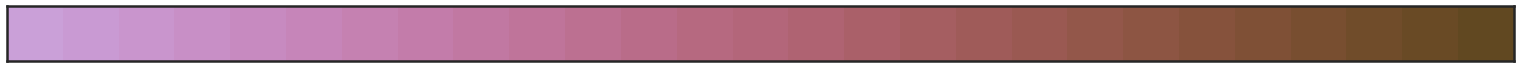

In [13]:
morph_pal = sns.cubehelix_palette(n_colors=4, start=0.6, rot=-0.6, gamma=1.0, hue=0.9, light=0.6, dark=0.3)
morph_cmap = sns.cubehelix_palette(n_colors=4, start=0.6, rot=-0.6, gamma=1.0, hue=0.9, light=0.3, dark=0.2, 
                                   as_cmap=True, reverse=True)
cell_pal = sns.cubehelix_palette(n_colors=9, start=1.7, rot=-0.8, gamma=1.0, hue=0.9, light=0.6, dark=0.3)
cell_cmap = sns.cubehelix_palette(n_colors=9, start=1.7, rot=-0.8, gamma=1.0, hue=0.9, light=0.3, dark=0.2, 
                                  as_cmap=True, reverse=True)
func_pal = sns.cubehelix_palette(n_colors=4, start=3.0, rot=-0.6, gamma=1.0, hue=0.9, light=0.6, dark=0.3)
func_cmap = sns.cubehelix_palette(n_colors=4, start=3.0, rot=-0.6, gamma=1.0, hue=0.9, light=0.3, dark=0.2, 
                                  as_cmap=True, reverse=True)

age_cmap = sns.cubehelix_palette(n_colors=27, start=0, rot=-0.8, gamma=1.0, hue=0.9, light=0.3, dark=0.2, 
                                  as_cmap=True, reverse=True)
age_pal = sns.cubehelix_palette(n_colors=27, start=5, rot=-0.8, gamma=1.0, hue=0.9, light=0.7, dark=0.3)

big_pal = morph_pal + cell_pal + func_pal
sns.palplot(age_pal)
sns.set(style="white", 
        context="poster", 
        font_scale=0.8,
        rc={"axes.facecolor": (0, 0, 0, 0),
            "font.monospace": 'Courier New',
            "font.family": 'monospace'})
crayons = sns.crayon_palette(['Aquamarine', 'Jungle Green', 'Fuchsia'])

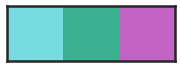

In [14]:
sns.palplot(crayons)

In [15]:
PROJ_DIR = "/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_clustering/"
DATA_DIR = "data/"
FIGS_DIR = "figures/"
OUTP_DIR = "output/"

In [16]:
df = pd.read_csv(join(PROJ_DIR, DATA_DIR, "data_qcd.csv"), index_col=0, header=0)

df.drop(list(df.filter(regex='lesion.*').columns), axis=1, inplace=True)
df.drop(list(df.filter(regex='.*_cf12_.*').columns), axis=1, inplace=True)
no_2yfu = df[df["interview_date.2_year_follow_up_y_arm_1"].isna() == True].index
df = df.drop(no_2yfu, axis=0)

In [17]:
deltasmri_complete = pd.concat([df.filter(regex='smri.*change_score'), 
                                df.filter(regex='mrisdp.*change_score')], axis=1).dropna()
deltarsfmri_complete = df.filter(regex='rsfmri.*change_score').dropna(how='any')
deltarsi_complete = df.filter(regex='dmri_rsi.*change_score').dropna()
deltadti_complete = df.filter(regex='dmri_dti.*change_score').dropna()

img_modalities = {'smri': deltasmri_complete,
                  'fmri': deltarsfmri_complete,
                  'rsi': deltarsi_complete, 
                  'dti': deltadti_complete}

#morph = img_modalities['smri'].filter(regex='.*vol.*').columns

# plot the distribution of variances of all structural mri measures
smri_var = img_modalities['smri'].columns
dti_var = img_modalities['dti'].columns
rsi_var = img_modalities['rsi'].columns
# separate wm and gm rsi
rsi_gm = list(img_modalities['rsi'].filter(regex='.*gm').columns) + list(img_modalities['rsi'].filter(regex='.*scs').columns)
rsi_wm = list(set(rsi_var) - set(rsi_gm))
rsi_scs = list(img_modalities['rsi'].filter(regex='.*scs').columns)
fmri_var = img_modalities['fmri'].columns
fc_cort_var = img_modalities['fmri'].filter(regex='_c_.*').columns
fc_scor_var = img_modalities['fmri'].filter(regex='_cor_.*').columns
fmri_var_var = img_modalities['fmri'].filter(regex='_var_.*').columns

#morph_var = df[df['concept'] == 'macrostructure'].index
#cell_var = df[df['concept'] == 'microstructure'].index
func_var = list(fmri_var_var) 
conn_var = list(fc_cort_var) + list(fc_scor_var)

btwn_fc = []
wthn_fc = []
for var in fc_cort_var:
    var_list = var[:-13].split('_')
    #print(var_list)
    if var_list[3] == var_list[5]:
        #print(var, 'within-network')
        wthn_fc.append(var)
    else:
        btwn_fc.append(var)
        #print(var, 'between-network')

In [18]:
imaging_apd = list(deltasmri_complete.columns) + list(deltadti_complete.columns) + list(deltarsi_complete.columns) + list(deltarsfmri_complete.columns)

In [19]:
concepts = {'morph': ['thick', 
                      'area', 
                      'vol',
                      'dtivol'],
            'cell': ['t1wcnt', 
                     'rsirni', 
                     'rsirnd',
                     'rsirnigm', 
                     'rsirndgm',
                     'dtifa', 
                     'dtimd',
                     'dtild', 
                     'dtitd'],
            'func':['var',
                    'c',
                    'cor',
                    #'subcortical-network fc'
                   ]}



In [29]:
analyses = ['Corr: Age, APC', 'Corr: Baseline, APC', 'PCorr: Age, APC', 'PCorr: Baseline, APC']
metrics = ['r', 'p(r)', 'concept', 'measure']
columns = pd.MultiIndex.from_product((analyses, metrics))
correlations = pd.DataFrame(columns=columns)
for var in imaging_apd:
    base_var = var.split('.')[0]
    temp_df = df[[var, 
                  f'{base_var}.baseline_year_1_arm_1', 
                  'interview_age.baseline_year_1_arm_1']].dropna()
    # correlation between start and change
    r, p = spearmanr(temp_df[var], temp_df[f'{base_var}.baseline_year_1_arm_1'])
    correlations.at[base_var, 
                    ('Corr: Baseline, APC', 'r')] = r
    correlations.at[base_var, 
                    ('Corr: Baseline, APC', 'p(r)')] = p
    # correlation between baseline age and change
    r, p = spearmanr(temp_df[var], temp_df['interview_age.baseline_year_1_arm_1'])
    correlations.at[base_var, 
                  ('Corr: Age, APC', 'r')] = r
    correlations.at[base_var, 
                  ('Corr: Age, APC', 'p(r)')] = p
    # partial correlation between start and change, controlling for age
    pcorr_df = partial_corr(temp_df, 
                        var,  
                        f'{base_var}.baseline_year_1_arm_1',
                        'interview_age.baseline_year_1_arm_1',)
    correlations.at[base_var, 
                  ('PCorr: Baseline, APC', 'r')] = pcorr_df.iloc[0]['r']
    correlations.at[base_var, 
                  ('PCorr: Baseline, APC', 'p(r)')] = pcorr_df.iloc[0]['p-val']
    # partial correlation between age and change, controlling for start
    pcorr_df = partial_corr(temp_df, 
                        var, 
                        'interview_age.baseline_year_1_arm_1', 
                        f'{base_var}.baseline_year_1_arm_1')
    correlations.at[base_var, 
                  ('PCorr: Age, APC', 'r')] = pcorr_df.iloc[0]['r']
    correlations.at[base_var, 
                  ('PCorr: Age, APC', 'p(r)')] = pcorr_df.iloc[0]['p-val']
    if 'mrisdp' in var:
        pass
    elif '_' in var:
        var_list = base_var.split('_')
        correlations.at[base_var, 
                        ('Corr: Age, APC', 'measure')] = var_list[1]
        if var_list[1] in concepts['morph']:
            correlations.at[base_var, 
                            ('Corr: Age, APC', 'concept')] = 'macrostructure'
        elif var_list[1] in concepts['cell']:
            correlations.at[base_var, 
                            ('Corr: Age, APC', 'concept')] = 'microstructure'
        if var_list[1] in concepts['func']:
            correlations.at[base_var, 
                            ('Corr: Age, APC', 'concept')] = 'function'
        if var in btwn_fc:
            correlations.at[base_var, 
                            ('Corr: Age, APC', 'measure')] = 'between-network fc'
        elif var in wthn_fc:
            correlations.at[base_var, 
                            ('Corr: Age, APC', 'measure')] = 'within-network fc'
        elif var in fc_scor_var:
            correlations.at[base_var, 
                            ('Corr: Age, APC', 'measure')] = 'subcortical-network fc'
        elif var in rsi_scs:
            if 'rsirni' in var:
                correlations.at[base_var, 
                                ('Corr: Age, APC', 'measure')] = 'rsirnigm'
            elif 'rsirnd' in var:
                correlations.at[base_var, 
                                ('Corr: Age, APC', 'measure')] = 'rsirndgm'
correlations.dropna(how='all', axis=1, inplace=True)

In [30]:
long_names = {'var': 'BOLD Variance',
              'between-network fc': 'Between FC',
              'within-network fc': 'Within FC',
              'subcortical-network fc': 'Subcortical FC',
              'dtivol': 'WM Volume',
              'vol': 'GM Volume',
              'thick': 'Cortical Thickness',
              'area': 'Cortical Area',
              'dtifa': 'WM FA',
              'dtimd': 'WM MD',
              'dtild': 'WM LD',
              'dtitd': 'WM TD',
              'rsirni': 'WM RNI',
              'rsirnd': 'WM RND',
              'rsirnigm': 'GM RNI',
              'rsirndgm': 'GM RND',
              't1wcnt': 'GM/WM'}

row_order = ['GM Volume', 'Cortical Thickness', 'Cortical Area', 'WM Volume',
             'GM/WM', 'WM FA', 'WM MD', 'WM LD', 'WM TD', 
             'WM RNI', 'GM RNI','WM RND','GM RND',
             'BOLD Variance', 'Between FC', 'Within FC', 'Subcortical FC']

In [31]:
correlations.replace(long_names, inplace=True)
correlations.columns = correlations.columns.to_flat_index()

In [32]:
correlations.rename({('Corr: Age, APC', 'measure'): 'measure',
                     ('Corr: Age, APC', 'concept'): 'concept',
                     ('PCorr: Baseline, APC', 'r'): 'Partial correlation: baseline, APΔ',
                     ('PCorr: Age, APC', 'r'): 'Partial correlation: age, APΔ'}, axis=1, inplace=True)

In [33]:
correlations = assign_region_names(correlations, missing=False)

In [34]:
correlations

,"(Corr: Age, APC, r)","(Corr: Age, APC, p(r))",concept,measure,"(Corr: Baseline, APC, r)","(Corr: Baseline, APC, p(r))","Partial correlation: age, APΔ","(PCorr: Age, APC, p(r))","Partial correlation: baseline, APΔ","(PCorr: Baseline, APC, p(r))",modality,atlas,region,long_region,hemisphere
smri_area_cdk_banksstslh,-0.071862,6.111504e-10,macrostructure,area,-0.151559,2.943361e-39,-0.064861,2.364154e-08,-0.185361,3.644718e-58,smri,cdk,banksstslh,Banks of Superior Temporal Sulcus,L
smri_area_cdk_cdacatelh,-0.072032,5.567526e-10,macrostructure,area,-0.082672,1.069159e-12,-0.061273,1.337891e-07,-0.086981,6.715201e-14,smri,cdk,cdacatelh,"Anterior Cingulate, Caudal",L
smri_area_cdk_cdmdfrlh,-0.110119,2.136508e-21,macrostructure,area,-0.116325,1.047525e-23,-0.078858,1.111792e-11,-0.177623,1.753186e-53,smri,cdk,cdmdfrlh,"Middle Frontal Gyrus, Caudal",L
smri_area_cdk_cuneuslh,-0.014167,2.231103e-01,macrostructure,area,-0.080473,4.173413e-12,-0.010481,3.674395e-01,-0.082706,1.050346e-12,smri,cdk,cuneuslh,Cuneus,L
smri_area_cdk_ehinallh,-0.011232,3.340923e-01,macrostructure,area,-0.223956,9.663931e-85,-0.004669,6.880778e-01,-0.255907,6.463422e-111,smri,cdk,ehinallh,Entorhinal Cortex,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rsfmri_cor_ngd_vs_scs_plrh,-0.005814,6.320632e-01,function,cor,-0.625387,0.000000e+00,0.005890,6.276119e-01,-0.517990,0.000000e+00,rsfmri,ngd,vs_scs_plrh,"Visual Network, Pallidum",L
rsfmri_cor_ngd_vs_scs_hprh,0.039747,1.040842e-03,function,cor,-0.657116,0.000000e+00,0.026252,3.036736e-02,-0.567435,0.000000e+00,rsfmri,ngd,vs_scs_hprh,"Visual Network, Hippocampus",R
rsfmri_cor_ngd_vs_scs_agrh,0.015607,1.980163e-01,function,cor,-0.616142,0.000000e+00,0.000591,9.611475e-01,-0.559539,0.000000e+00,rsfmri,ngd,vs_scs_agrh,"Visual Network, Amygdala",R
rsfmri_cor_ngd_vs_scs_aarh,0.028497,1.878344e-02,function,cor,-0.657971,0.000000e+00,0.011224,3.548254e-01,-0.578684,0.000000e+00,rsfmri,ngd,vs_scs_aarh,"Visual Network, Accumbens",R


In [35]:
correlations.to_csv(join(PROJ_DIR, OUTP_DIR,'start_change_region_names.csv'))

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


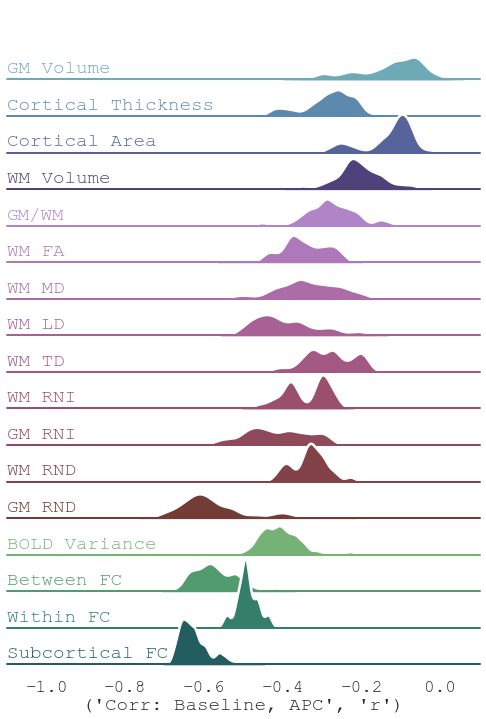

In [49]:
g = sns.FacetGrid(correlations, 
                  row="measure", row_order=row_order,
                  hue="measure", hue_order=row_order,
                  aspect=12.5, 
                  height=.6, palette=big_pal, xlim=(-1.1,0.1))

# Draw the densities in a few steps
g.map(sns.kdeplot, ('Corr: Baseline, APC', 'r'),
      bw_adjust=.55, clip_on=False,
      fill=True, alpha=1, linewidth=1.)
g.map(sns.kdeplot, ('Corr: Baseline, APC', 'r'), clip_on=False, color="w", lw=2.5, bw_adjust=.55)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .15, label, #fontweight="bold", 
            color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, ('Corr: Baseline, APC', 'r'))

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-0.5)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.savefig(f'../{FIGS_DIR}/start_change_corr.png', dpi=400)

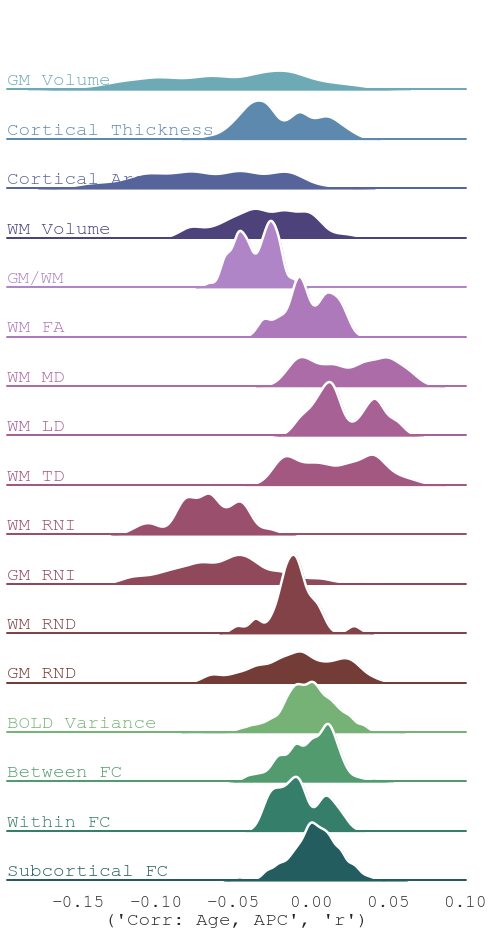

In [45]:
g = sns.FacetGrid(correlations, 
                  row="measure", row_order=row_order,
                  hue="measure", hue_order=row_order,
                  aspect=10, 
                  height=.8, palette=big_pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, ('Corr: Age, APC', 'r'),
      bw_adjust=.55, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, ('Corr: Age, APC', 'r'), clip_on=False, color="w", lw=2.5, bw_adjust=.55)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .1, label, #fontweight="bold", 
            color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, ('Corr: Age, APC', 'r'))

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-0.4)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.savefig(f'../{FIGS_DIR}/age_change_corr.png', dpi=400)

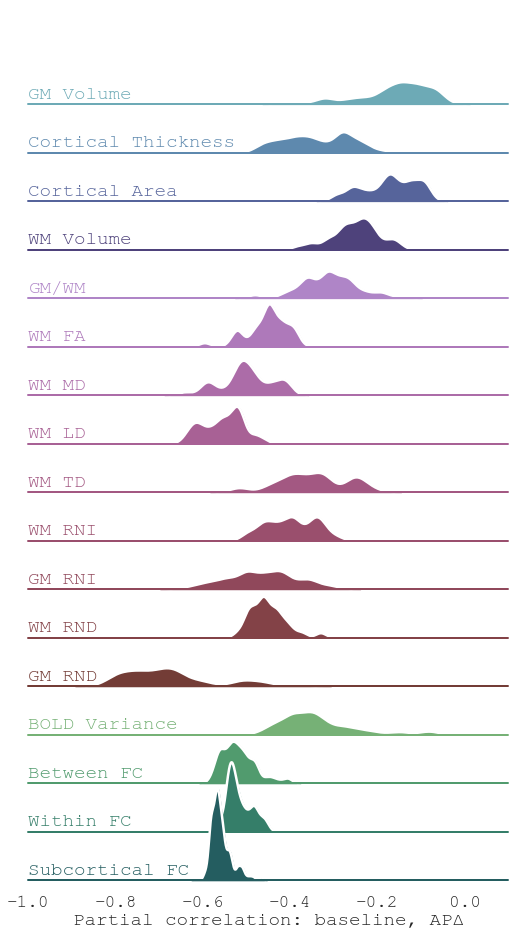

In [50]:
g = sns.FacetGrid(correlations, 
                  row="measure", row_order=row_order,
                  hue="measure", hue_order=row_order,
                  aspect=10, 
                  height=.8, palette=big_pal, xlim=(-1,0.1))

# Draw the densities in a few steps
g.map(sns.kdeplot, 'Partial correlation: baseline, APΔ',
      bw_adjust=.55, clip_on=False,
      fill=True, alpha=1, linewidth=1.)
g.map(sns.kdeplot, 'Partial correlation: baseline, APΔ', clip_on=False, color="w", lw=2.5, bw_adjust=.55)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .1, label, #fontweight="bold", 
            color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, 'Partial correlation: baseline, APΔ')

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-0.5)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.savefig(f'../{FIGS_DIR}/start_change_minus_age_pcorr.png', dpi=400)

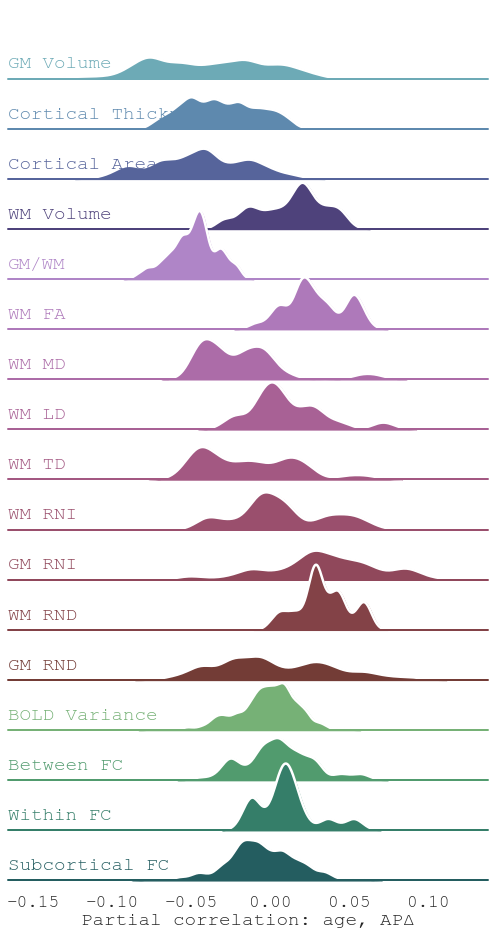

In [26]:
#sns.set_theme(context='talk', style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
g = sns.FacetGrid(correlations, 
                  row="measure", row_order=row_order,
                  hue="measure", hue_order=row_order,
                  aspect=10, 
                  height=.8, palette=big_pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, 'Partial correlation: age, APΔ',
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, 'Partial correlation: age, APΔ', clip_on=False, color="w", lw=2.5, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, #fontweight="bold", 
            color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, 'Partial correlation: age, APΔ')

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-0.3)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.savefig(f'../{FIGS_DIR}/age_change_minus_start_pcorr.png', dpi=400)

In [27]:
temp_df = correlations[correlations['measure'] == 'FC (sc)']
prop_sig = np.sum(temp_df[('Corr: Age, APC', 'p(r)')] < 0.01) / len(temp_df.index)
temp_df.describe(percentiles=[.25,.75]).loc['75%']['Partial correlation: baseline, APΔ']

/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_30669/419169042.py:2: RuntimeWarning: invalid value encountered in long_scalars
  prop_sig = np.sum(temp_df[('Corr: Age, APC', 'p(r)')] < 0.01) / len(temp_df.index)


nan

In [28]:
# build a table with correlations for each measure
stats = ['mean', '(Q1,Q3)', '%sig']
meas = ['Pearson: age, APΔ', 'Pearson: baseline, APΔ', 'Partial: age, APΔ', 'Partial: baseline, APΔ']
columns = pd.MultiIndex.from_product([meas, stats])
corr_stats = pd.DataFrame(columns=columns)
for measure in correlations['measure'].unique():
    temp_df = correlations[correlations['measure'] == measure]
    descriptives = temp_df.describe()
    
    # I want mean correlation, quartiles, and proportion of regions that are significantly correlated
    corr_stats.at[measure, ('Pearson: age, APΔ', 'mean')] = descriptives.loc['mean'][('Corr: Age, APC', 'r')]
    corr_stats.at[measure, ('Pearson: baseline, APΔ', 'mean')] = descriptives.loc['mean'][('Corr: Baseline, APC', 'r')]
    corr_stats.at[measure, ('Partial: age, APΔ', 'mean')] = descriptives.loc['mean']['Partial correlation: age, APΔ']
    corr_stats.at[measure, ('Partial: baseline, APΔ', 'mean')] = descriptives.loc['mean']['Partial correlation: baseline, APΔ']
    
    # quartiles are already calculated in `descriptives`
    q1 = descriptives.loc['25%']
    q3 = descriptives.loc['75%']
    # need to round these (:)
    corr_stats.at[measure, ('Pearson: age, APΔ', '(Q1,Q3)')] = (np.round(q1[('Corr: Age, APC', 'r')],2), np.round(q3[('Corr: Age, APC', 'r')],2))
    corr_stats.at[measure, ('Pearson: baseline, APΔ', '(Q1,Q3)')] = (np.round(q1[('Corr: Baseline, APC', 'r')],2), np.round(q3[('Corr: Baseline, APC', 'r')],2))
    corr_stats.at[measure, ('Partial: age, APΔ', '(Q1,Q3)')] = (np.round(q1['Partial correlation: age, APΔ'],2), np.round(q3['Partial correlation: age, APΔ'],))
    corr_stats.at[measure, ('Partial: baseline, APΔ', '(Q1,Q3)')] = (np.round(q1[('Partial correlation: baseline, APΔ')],2), np.round(q3[('Partial correlation: baseline, APΔ')],2))
    
    # proportion of regions with significant (p)corrs
    prop_sig = np.sum(temp_df[('Corr: Age, APC', 'p(r)')] < 0.01) / len(temp_df.index)
    corr_stats.at[measure, ('Pearson: age, APΔ', '%sig')] = prop_sig
    
    prop_sig = np.sum(temp_df[('Corr: Baseline, APC', 'p(r)')] < 0.01) / len(temp_df.index)
    corr_stats.at[measure, ('Pearson: baseline, APΔ', '%sig')] = prop_sig
    
    prop_sig = np.sum(temp_df['Partial correlation: age, APΔ'] < 0.01) / len(temp_df.index)
    corr_stats.at[measure, ('Partial: age, APΔ', '%sig')] = prop_sig
    
    prop_sig = np.sum(temp_df['Partial correlation: baseline, APΔ'] < 0.01) / len(temp_df.index)
    corr_stats.at[measure, ('Partial: baseline, APΔ', '%sig')] = prop_sig
    

In [29]:
corr_stats = corr_stats.loc[row_order]
corr_stats.to_csv(join(PROJ_DIR, OUTP_DIR, 'APC_startchange_summary.csv'))

## Below this is copy-pasta code from the 1.2 APC for plotting in brain space
Repurpose for plotting _only significant_ start-change correlations.

In [ ]:
morph_cmap = sns.diverging_palette(12, 256.3, s=70, l=50, center="light", as_cmap=True)
func_cmap = sns.diverging_palette(343, 140.9, s=70, l=50, center="light", as_cmap=True)
cell_cmap = sns.diverging_palette(31, 294.3, s=70, l=50, center="light", as_cmap=True)
morph_pal = sns.diverging_palette(12, 256.3, s=70, l=50, center="light", as_cmap=False)
func_pal = sns.diverging_palette(343, 140.9, s=70, l=50, center="light", as_cmap=False)
cell_pal = sns.diverging_palette(31.0, 294.3, s=70, l=50, center="light", as_cmap=False)
sns.palplot(morph_pal + func_pal + cell_pal)

pals = {'cortical-thickness': morph_cmap,
        'cortical-gwcontrast': cell_cmap,
            'cortical-area': morph_cmap,
            'cortical-volume': morph_cmap, 
            'subcortical-volume': morph_cmap, 
            'subcortical-RND': cell_cmap,
            'subcortical-RNI': cell_cmap,
            'cortical-RND': cell_cmap,
            'cortical-RNI': cell_cmap,
            'cortical-BOLD-variance': func_cmap,
            'tract-volume': morph_cmap, 
            'tract-FA': cell_cmap, 
            'tract-MD': cell_cmap,
            'tract-LD': cell_cmap, 
            'tract-TD': cell_cmap,
            'tract-RND': cell_cmap,
            'tract-RNI': cell_cmap,
        'cortical-network-connectivity': func_cmap,
            'subcortical-network-connectivity': func_cmap}

In [ ]:
# let's plot APC on brains pls
for measure in measures:
    if 'BOLD' in measure:
        vmax = 3.5
    else: 
        vmax = 1.5
    print(measure)
    meas_df = descriptives.filter(regex=measures[measure], axis=0)
    meas_vars = [i.split('.')[0] for i in meas_df.index]
    #print(nifti_mapping.loc[meas_vars]['atlas_fname'])
    atlas_fname = nifti_mapping.loc[meas_vars]['atlas_fname'].unique()[0]
    print(atlas_fname)
    atlas_nii = nib.load(atlas_fname)
    atlas_arr = atlas_nii.get_fdata()
    plotting_arr = np.zeros(atlas_arr.shape)
    if 'tract' in measure:
        fibers = nifti_mapping.filter(regex=measures[measure], axis=0).index
        var = fibers[0]
        tract_fname = nifti_mapping.loc[var]['atlas_fname']
        tract_nii = nib.load(tract_fname)
        tract_arr = tract_nii.get_fdata()
        #print(np.unique(tract_arr))
        avg = descriptives.at[f'{var}.change_score', 'annualized percent change']
        tract_arr *= avg
        all_tracts_arr = np.zeros(tract_arr.shape)
        all_tracts_arr += tract_arr
        for var in fibers[1:]:    
            tract_fname = nifti_mapping.loc[var]['atlas_fname']
            if type(tract_fname) is str:
                try:
                    tract_nii = nib.load(tract_fname)
                    tract_arr = tract_nii.get_fdata()
                    #print(np.unique(tract_arr))
                    avg = descriptives.at[f'{var}.change_score', 'annualized percent change']
                    tract_arr *= avg
                    all_tracts_arr += tract_arr
                except Exception as e:
                    pass
            else:
                pass
        meas_nimg = nib.Nifti1Image(all_tracts_arr, tract_nii.affine)
        #plt.figure(layout='tight')
        #fig,ax = plt.subplots(ncols=2, gridspec_kw=grid_kw, figsize=(24,4))
        q = plotting.plot_anat(meas_nimg, display_mode='z',  threshold=0.01,
                            cut_coords=[35,50,65,85], 
                            black_bg=False,
                                vmax=vmax*1.1, 
                                vmin=-vmax*1.1,
                                annotate=False, cmap=pals[measure], colorbar=False,
                                #axes=ax[0]
                            )
        q.close()
        q.savefig(f'{PROJ_DIR}/figures/APC_{measure}.png', dpi=400)
        q = None
    else:
        for i in meas_df.index:
            j = i.split('.')[0]
            value = nifti_mapping.loc[j]['atlas_value']
            #print(i, value)
            if value is np.nan:
                pass
            else:
                avg = descriptives.at[i, 'annualized percent change']
                plotting_arr[np.where(atlas_arr == value)] = avg
        meas_nimg = nib.Nifti1Image(plotting_arr, atlas_nii.affine)
        if 'subcortical' in measure:
            fig,ax = plt.subplots()
            #plt.figure(layout='tight')
            q = plotting.plot_stat_map(meas_nimg, display_mode='z',  threshold=0.01,
                                   cut_coords=[-20, -10, 0, 10], vmax=vmax*1.1, 
                                   annotate=False, cmap=pals[measure], colorbar=False,
                                   symmetric_cbar=False, axes=ax)

            q.savefig(f'{PROJ_DIR}/figures/APC_{measure}.png', dpi=400)
        elif 'cortical' in measure:
            figure = plot_surfaces(meas_nimg, fsaverage, pals[measure], vmax, 0.01)
            figure.savefig(f'{PROJ_DIR}/figures/APC_{measure}.png', dpi=400, bbox_inches='tight')